# Good Film // Bad Film
## Film Plot Synopses and etc. as Predictors of Critical Reception

This notebook builds a classifier which predicts whether or not a film will be "good" or "bad" based on the plot synopsis, the popularity of the leading actors, and other variables such as genre. "Good" films are those which perform better than the mean of all of the IMdB critic's rating scores in the dataset, while "bad" films score lower than that mean.

In [74]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', color_codes=True)

import nltk
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import enchant
english_d = enchant.Dict("en_US")
import re
import gensim
from gensim import corpora, models, similarities
import pickle

import pyLDAvis
import pyLDAvis.gensim

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

import xgboost as xgb
from xgboost import XGBClassifier
from patsy import dmatrices

## Get the data

In [2]:
imdb = pd.read_csv('imdb_5000_movies.csv') # Just a big Kaggle dataset full of movies.

One really nice thing about this dataset is that it provides the unique IMdB movie ID's, which we can pass to another API in order to supplement our data with more features. A key to the OMdB API cost a minimum of one dollar. Here we parse out those IMdB ID's:

In [3]:
imdb_ids = [imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0] for i in range(len(imdb))]

Here we make the API calls, and persist our data to little .txt files:

In [4]:
# for id in imdb_ids:

#     request = requests.get(f'http://www.omdbapi.com/?i={id}&plot=full&apikey={API_KEY}').json()
#     text = str(request)  
    
#     f = open(f'movie_{id}', 'w+')
#     f.write(text)
#     f.close()

This is what we want our eventual pandas dataFrame to look like:

In [5]:
df = pd.DataFrame(columns=['Title', 'Year', 'ID', 'Plot', 'Genre', 'Production', 
                           'Director', 'Actor_1_name', 'Actor_1_fb_likes', 'Actor_2_name', 
                           'Actor_2_fb_likes', 'Actor_3_name', 'Actor_3_fb_likes', 'Budget', 
                           'Rated', 'Language', 'imdbRating'])

This is where we frankenstein together the kaggle dataset with what we got from OMdB:

In [6]:
for i in range(len(imdb_ids)):
    id = imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0]
    x_file = open(os.path.join('Movies', f"movie_{id}"), "r") # Open up each movie's text file
    movie_text = x_file.readlines()[0]
    dict = eval(movie_text) # Coerce string to dictionary
    dict['Plot'] = dict['Plot'].replace("\'", "'") # Cleanup
    df = df.append({'Title': dict['Title'], 'Year': dict['Year'], 'ID': id, 
                    'Plot': dict['Plot'], 'Genre': dict['Genre'], 
                    'imdbRating': dict['imdbRating'], 
                    'Director': imdb.iloc[i,:].loc['director_name'], 
                    'Actor_1_name':imdb.iloc[i,:].loc['actor_1_name'], 
                    'Actor_1_fb_likes':imdb.iloc[i,:].loc['actor_1_facebook_likes'], 
                    'Actor_2_name':imdb.iloc[i,:].loc['actor_2_name'], 
                    'Actor_2_fb_likes':imdb.iloc[i,:].loc['actor_2_facebook_likes'], 
                    'Actor_3_name':imdb.iloc[i,:].loc['actor_3_name'], 
                    'Actor_3_fb_likes':imdb.iloc[i,:].loc['actor_3_facebook_likes'], 
                    'Budget':imdb.iloc[i,:].loc['budget'], 'Language':dict['Language'], 
                    'Rated':dict['Rated']}, ignore_index=True) # Add to dataframe

Here's our beautiful new dataFrame:

In [7]:
df.iloc[:3,:]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8


## Munging and EDA

We drop datapoints with null 'imdbRating' values, since that is our independent / target variable. We also convert these into binary; we are only concerned with whether or not a film's 'imbdRating' is above the mean (1) or below the mean (0). This binary value is saved into a new column called 'binary_target'.

Null values in the 'actor facebook likes' column were imputed from the column mean.

In [8]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)

In [9]:
df = df.reset_index()
df = df.drop(['index'], axis=1)
df[:3]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating,binary_target
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8,1
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1,1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8,1


### One-hot encoding Genres

In [10]:
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

#create a list of lists, where each element is a list of a movie's classified genres
li = []
[li.append(df.iloc[i]['Genre'].split(', ')) for i in range(len(df))]

#adding columns to df for each genre, 1 represents the movie is classified under that genre, 0 is that it is not
for genre in final_genres:
    list = []
    [list.append(1) if genre in movie
    else list.append(0) for movie in li]
    df[genre] = list

### Creating a fresh DataFrame with everything but Plot Text Features

In [11]:
main_df = pd.DataFrame()

#join the features we want to narrow in on with our target variable
genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Musical,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Log Transforming "Actor Facebook Likes"

'Actor_1_fb_likes' had some striking outliers and needed a log transform:

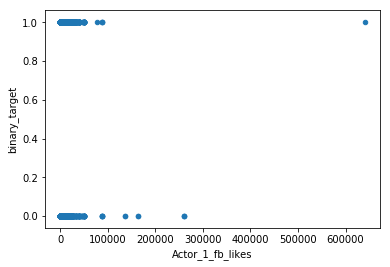

In [15]:
df.plot.scatter(x='Actor_1_fb_likes',
                    y='binary_target')

In [16]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

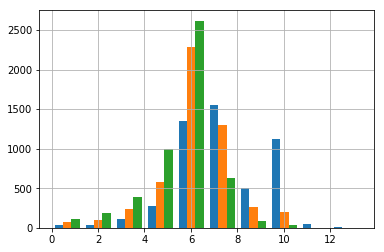

In [17]:
pd.Series(actor_likes).hist()

Looks way more gaussian after a log transform. We add these logged features to our dataframe:

In [18]:
main_df = main_df.join(actor_likes)
main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western,Actor_1_fb_likes_logged,Actor_2_fb_likes_logged,Actor_3_fb_likes_logged
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.908755,6.842683,6.752270
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10.596660,8.517393,6.908755
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9.305741,5.976351,5.087596


### Baseline Logistic Regression without Plot-Text Features

Now that we've cleaned up a bit, we'll start throwing our features at a statsmodels logistic regression estimator to evaluate r^2 and p-values of various features.

In [20]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588562
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4005
Method:                           MLE   Df Model:                           23
Date:                Sun, 24 Feb 2019   Pseudo R-squ.:                  0.1485
Time:                        19:48:34   Log-Likelihood:                -2371.3
converged:                       True   LL-Null:                       -2784.7
                                        LLR p-value:                7.246e-160
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  85.6656      6.990     12.255      0.000      71.965   

0.6865079365079365

This gives us an idea of which features might be less important in the determination of what makes a movie "good". We'll drop the less pertinent features and try again:

In [21]:
s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588716
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4013
Method:                           MLE   Df Model:                           15
Date:                Sun, 24 Feb 2019   Pseudo R-squ.:                  0.1482
Time:                        19:49:17   Log-Likelihood:                -2371.9
converged:                       True   LL-Null:                       -2784.7
                                        LLR p-value:                2.871e-166
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  85.2044      6.931     12.293      0.000      71.620   

0.6884920634920635

In [22]:
main_df.columns

Index(['Year', 'binary_target', 'Action', 'Animation', 'Biography', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Horror', 'Mystery', 'Romance',
       'Sci_Fi', 'Thriller', 'Actor_1_fb_likes_logged',
       'Actor_2_fb_likes_logged', 'Actor_3_fb_likes_logged'],
      dtype='object')

These are the features we're sticking with for now.

### Correlation Matrices

We'd be remiss not to check for overly correlated features:

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserW

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])


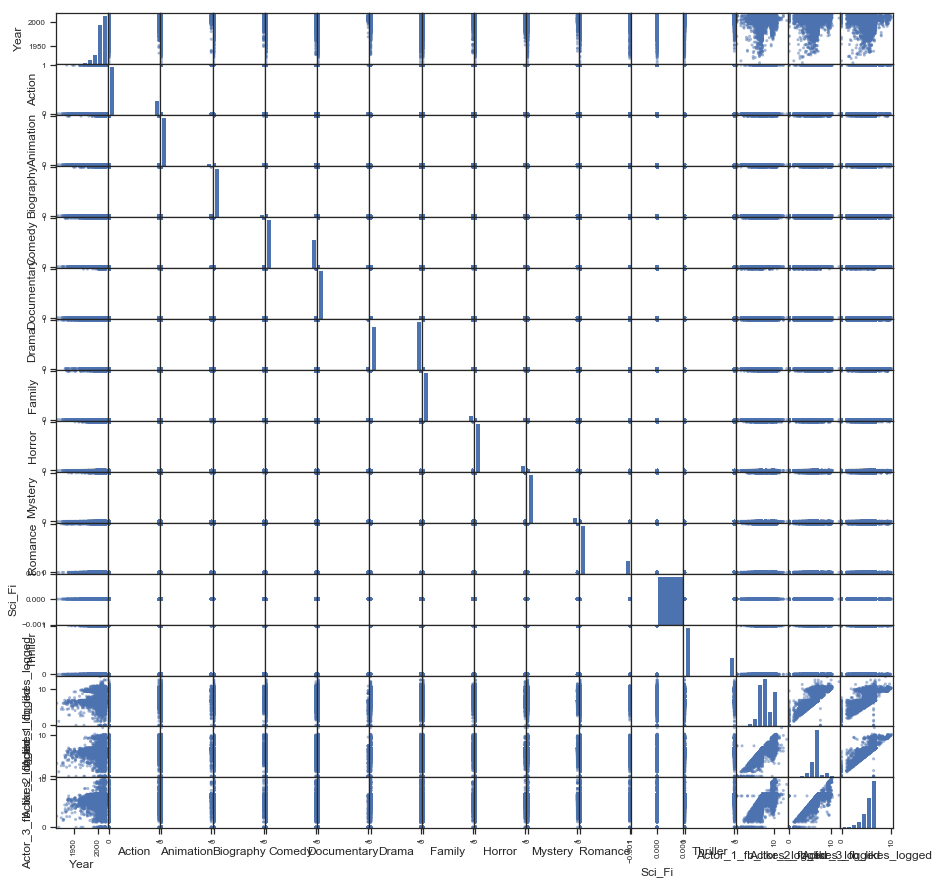

In [26]:
# Creating a multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

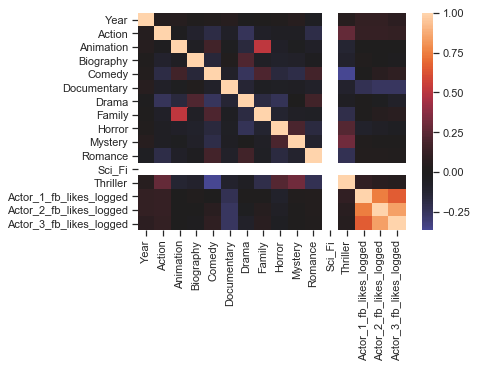

In [29]:
sns.heatmap(main_corr.corr(), center=0);

It's fairly intuitive that the social media popularity of the leading actors would be positively correlated, but we'll leave it in in case there are deviations from that norm. It's interesting to note that films in the "animation" genre are so commonly also in the "family" genre. Makes sense too.

## Using NLP to get features from the Plot Synopses

#### Setting up Lemmatization / Normalization Functions:

In [33]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize(plot_list):
    lemmatized_plots = []
    
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower()) # Make plot summary lowercase and lemmatize        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower] # Lemmatize
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        # Filter out words that don't match this regex pattern:
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        # Remove stop words
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        lemmatized_plots.append(lemmatized_string)
        
    return lemmatized_plots

In [34]:
def get_wordnet_pos(word):
    """Map POS tag to the first character that lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

### Run the Lemmatizer

In [38]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all movie plots.
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [39]:
# Term frequency = Number of times a word appears in a document / number of words in document
# Inverse document frequency = log base e(number of documents / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

(5037, 13807)


Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA; Clustering Documents by Topic

Gensim clusters words that appear together frequently. The clusters can be interpreted as general topics, and each movie gets weights indicating the degree to which it belongs to each topic. These weights are then re-incorporated as features in our dataset.

In [40]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [43]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('pickles/corpus.pkl', 'wb'))
dictionary.save('pickles/dictionary.gensim')

In [53]:
NUM_TOPICS = 30 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('pickles/model5.gensim')

In [54]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

[(11, '0.013*"young" + 0.011*"one" + 0.010*"house" + 0.009*"family"'),
 (12, '0.049*"school" + 0.027*"high" + 0.020*"student" + 0.018*"girl"'),
 (13, '0.012*"harry" + 0.010*"mike" + 0.010*"life" + 0.008*"make"'),
 (21, '0.043*"war" + 0.029*"john" + 0.024*"army" + 0.013*"soldier"'),
 (20, '0.013*"life" + 0.012*"family" + 0.010*"get" + 0.009*"friend"'),
 (27, '0.024*"life" + 0.011*"love" + 0.010*"one" + 0.009*"father"'),
 (24, '0.049*"team" + 0.014*"coach" + 0.013*"football" + 0.012*"player"'),
 (4, '0.024*"johnny" + 0.022*"dog" + 0.019*"billy" + 0.014*"victor"'),
 (8, '0.037*"henry" + 0.034*"grace" + 0.019*"mickey" + 0.016*"molly"'),
 (5, '0.012*"prison" + 0.009*"president" + 0.008*"two" + 0.008*"rick"'),
 (16, '0.011*"kill" + 0.010*"bad" + 0.008*"slave" + 0.007*"man"'),
 (6, '0.012*"world" + 0.011*"find" + 0.009*"friend" + 0.008*"must"'),
 (10, '0.017*"young" + 0.015*"man" + 0.012*"father" + 0.009*"new"'),
 (18, '0.024*"town" + 0.012*"people" + 0.012*"planet" + 0.011*"earth"'),
 (3, '0

In [55]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.194866  0.063630       1        1  19.397636
27    -0.168164  0.086588       2        1   6.925383
6     -0.135020 -0.033905       3        1   6.214505
28    -0.061756 -0.187953       4        1   6.025095
11    -0.127094 -0.002558       5        1   5.276824
20    -0.132873  0.083470       6        1   4.457117
15    -0.089917 -0.015510       7        1   3.986352
12    -0.132979  0.090554       8        1   3.800249
13    -0.097023  0.017888       9        1   3.771212
17    -0.102578  0.067372      10        1   3.514612
22    -0.039704 -0.100437      11        1   3.408444
10    -0.063849 -0.048849      12        1   3.176444
9     -0.023406  0.035048      13        1   2.530022
0      0.015543 -0.161517      14        1   2.482597
26    -0.012456 -0.019506      15        1   2.315435
19    -0.014462 -0.066046      16        1   2.292428
21     0.091369 -0.181693      17        1   2.178019
18     0.005710 -0.068760      18        1   2.162649
1     -0.023131  0.034378      19        1   2.127635
2     -0.001951  0.178134      20        1   1.953492
24     0.058061 -0.063572      21        1   1.899821
29     0.057230 -0.004631      22        1   1.708953
23     0.094056 -0.102924      23        1   1.385315
16     0.095134 -0.028446      24        1   1.369696
25     0.110239  0.037653      25        1   1.328348
4      0.072637  0.109455      26        1   1.260350
5      0.147584  0.001857      27        1   1.150926
14     0.146793  0.136874      28        1   0.850452
8      0.246834  0.068877      29        1   0.602527
3      0.280040  0.074528      30        1   0.447470, topic_info=     Category         Freq            Term        Total  loglift  logprob
359   Default   582.000000          school   582.000000  30.0000  30.0000
2124  Default   515.000000            film   515.000000  29.0000  29.0000
544   Default   419.000000            team   419.000000  28.0000  28.0000
230   Default   407.000000             war   407.000000  27.0000  27.0000
212   Default  2038.000000            life  2038.000000  26.0000  26.0000
207   Default   307.000000            john   307.000000  25.0000  25.0000
658   Default   537.000000            town   537.000000  24.0000  24.0000
607   Default   361.000000            high   361.000000  23.0000  23.0000
739   Default   251.000000           movie   251.000000  22.0000  22.0000
101   Default   221.000000            jack   221.000000  21.0000  21.0000
3678  Default   192.000000           frank   192.000000  20.0000  20.0000
1149  Default  1070.000000          family  1070.000000  19.0000  19.0000
248   Default  1172.000000          friend  1172.000000  18.0000  18.0000
284   Default  1002.000000           young  1002.000000  17.0000  17.0000
696   Default   549.000000            girl   549.000000  16.0000  16.0000
68    Default   849.000000           world   849.000000  15.0000  15.0000
2141  Default   302.000000         student   302.000000  14.0000  14.0000
244   Default   839.000000          father   839.000000  13.0000  13.0000
1114  Default   234.000000            star   234.000000  12.0000  12.0000
270   Default   428.000000    relationship   428.000000  11.0000  11.0000
460   Default  1407.000000             get  1407.000000  10.0000  10.0000
194   Default   175.000000            army   175.000000   9.0000   9.0000
255   Default   221.000000          killer   221.000000   8.0000   8.0000
31    Default   522.000000            kill   522.000000   7.0000   7.0000
1025  Default   565.000000             son   565.000000   6.0000   6.0000
761   Default   770.000000           story   770.000000   5.0000   5.0000
662   Default   462.000000            wife   462.000000   4.0000   4.0000
3869  Default   119.000000             tom   119.000000   3.0000   3.0000
106   Default   942.000000            make   942.000000   2.0000   2.0000
2707  Def

In [56]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(NUM_TOPICS)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [57]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.080214,0.0,0.0,0.0,0.0,0.000000,0.000000,0.234985,0.0,0.000000,...,0.0,0.000000,0.000000,0.37558,0.0,0.0,0.0,0.107889,0.160669,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.114041,0.477888,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.210998,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.094236,0.0,0.238233,...,0.0,0.132972,0.309032,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.436187,0.0,0.0,0.0,0.0,0.227184,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.174008,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.080170,0.630039,0.0,0.053912,...,0.0,0.106180,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.085895,0.0


### Joining GenSim Results with Vectorized Plot Synopses

In [58]:
plots_and_topics = tfidf_df.join(tm)

In [59]:
plots_and_topics.head()

,aardvark,aback,abandon,abandonment,abate,abatement,abbey,abdicate,abduct,abduction,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.37558,0.0,0.0,0.0,0.107889,0.160669,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.210998,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.132972,0.309032,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.174008,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.106180,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.085895,0.0


## Dimensionality Reduction with SVD - For the PlotText Data

In [60]:
svd = TruncatedSVD(n_components=14, n_iter=3, random_state=42)
plots_and_topics_pca = pd.DataFrame(svd.fit_transform(plots_and_topics))
print(svd.explained_variance_ratio_.sum())

0.17594584403561764


## Joining PlotText with the Other Features

In [61]:
df = main_df.join(plots_and_topics_pca)
len(df.columns)

31

## Advanced Models

In [63]:
X = df.drop(['binary_target'], axis=1)
y = df.binary_target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.1, random_state=15)

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


train_test_split on X_scaled:

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.1, random_state=15)

First we'll try a simple Gaussian Naive Bayes Model:

In [65]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.54      0.84      0.66       227
           1       0.76      0.41      0.53       277

   micro avg       0.60      0.60      0.60       504
   macro avg       0.65      0.62      0.59       504
weighted avg       0.66      0.60      0.59       504



Now we'll go nuts and try an XGBClassifier model:

In [66]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 74.7%
Test accuracy: 73.21%


In [70]:
y_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.7983587525246902


AUC: 0.7983587525246902


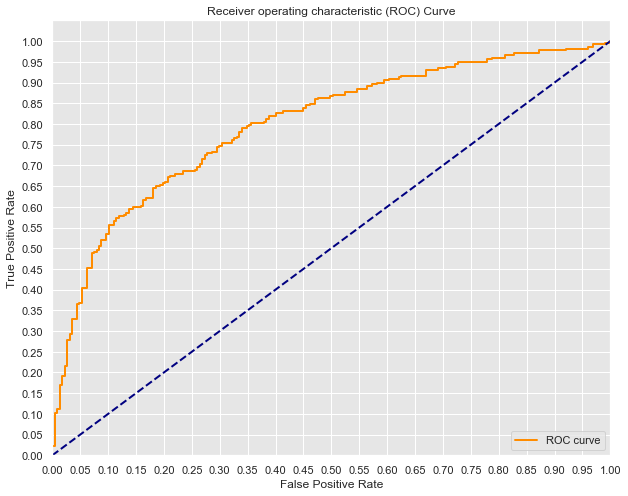

In [72]:
def draw_roc_curve(fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
draw_roc_curve(fpr,tpr)

Looks like we're off to a good start!

## Grid Searching for ideal dimensionality and classifier parameters

In [82]:
pipe = Pipeline([
    ('reduce_dim', TruncatedSVD()),
    ('classify', XGBClassifier())
])

score = {'f1': 'f1', 'accuracy': 'accuracy'}

N_FEATURES_OPTIONS = [3,7,14,20]

itera = [3, 5, 7]
n_est = [50,80,100,120,200]
# max_dep = [2,3,4,5]
# min_samp = [4,5,6,10]

param_grid = [
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est,
#         'classify__max_depth': max_dep,
#         'classify__min_samples_split':min_samp
    }]

reducer_labels = ['TruncatedSVD']

grid_adc = GridSearchCV(pipe, n_jobs=-1, param_grid=param_grid, scoring=score, refit='accuracy')
grid_adc.fit(X_train, y_train)
grid_adc.best_params_

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'classify__n_estimators': 200,
 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=20, n_iter=3,
        random_state=None, tol=0.0),
 'reduce_dim__n_components': 20,
 'reduce_dim__n_iter': 3}

In [83]:
# Check the gridsearch results:
y_preds = grid_adc.predict(X_test)
accuracy_score(y_test, y_preds)

0.6984126984126984

In [84]:
y_score = grid_adc.predict_proba(X_test)
fpr_gs, tpr_gs, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr_gs, tpr_gs)))

AUC: 0.762957426167719


AUC: 0.7983587525246902


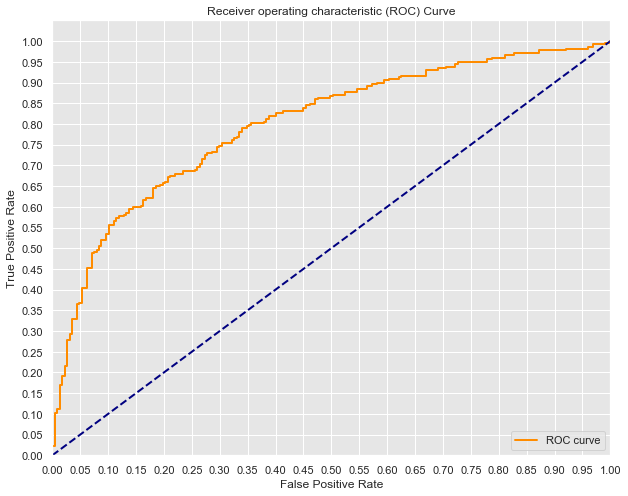

In [85]:
draw_roc_curve(fpr,tpr)

<Figure size 432x288 with 0 Axes>

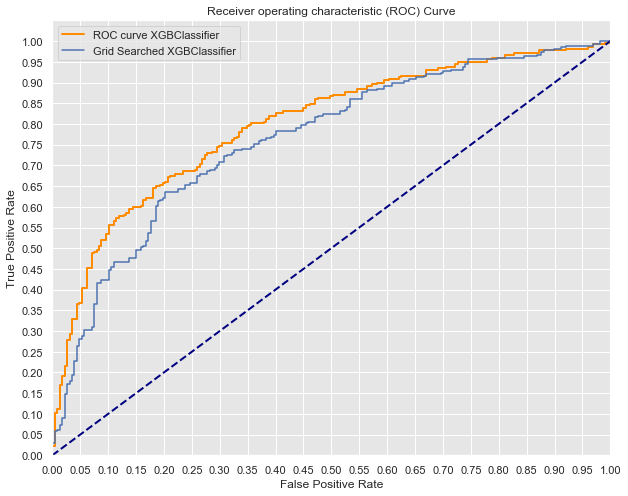

In [86]:
plt.figure(0).clf()

# pred = np.random.rand(1000)
# label = np.random.randint(2, size=1000)
# fpr, tpr, thresh = metrics.roc_curve(label, pred)
# auc = metrics.roc_auc_score(, pred)
# pred = np.random.rand(1000)
# label = np.random.randint(2, size=1000)
# fpr, tpr, thresh = metrics.roc_curve(label, pred)
# auc = metrics.roc_auc_score(label, pred)
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve XGBClassifier')
plt.plot(fpr_gs,tpr_gs,label='Grid Searched XGBClassifier')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.legend(loc=0)

Looks like it actually scored better before we tried to tune it